In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
from fastai.callbacks import *

In [2]:
D = 10
def fitness_func(indiv, b, t): return (indiv.data**2).sum()
def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)
ab = [1.] * 100
population = Population.new_random(dimension=D)

opt = Optimization(population, fitness_func, constraint_func, constraint_params=[ab],
                   max_times=100, frequency=0.5, evolve_mechanism=EvolveMechanism.CrowdingCosine)
opt.state_dict

{'gen': 0, 'evals': 0, 'time': 0, 'time_evals': 0, 'best': None}

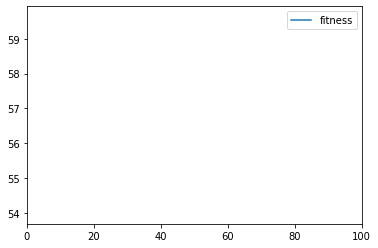

Total time: 00:00


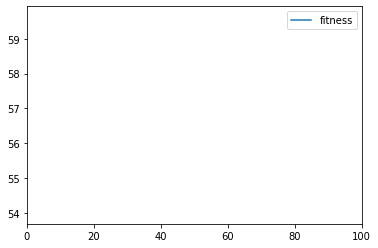

In [3]:
opt.run(2)

In [4]:
population.fitness_values

[84.82186333617588,
 70.22956670209466,
 32.29134477769281,
 60.507695063320455,
 100.3060711854823,
 73.92570173137673,
 48.94891099927032,
 69.04736064337317,
 68.21951242066683,
 50.5671908821518,
 46.69973764196429,
 57.524332939720175,
 60.224131894470105,
 66.75038539186589,
 69.73089227421333,
 72.68773809550409,
 55.63796634293263,
 46.498939812278564,
 139.42396239169193,
 43.89696691892758]

In [43]:
population[0].fitness_value

39.890753671537404

In [2]:
path = Path('../../data/results/exp1/sphere')

In [3]:
ab = pd.read_csv(path/'dC_01.csv')['b'].values
df = pd.read_csv(path/'best_known.csv')
best_known_fitness = df['fitness'].values
best_known_sumcv   = df['sum_constraints'].values

In [4]:
D = 30
nn_window = 5
nn_nf = 4
frequency = 1_000
max_times = len(ab)
total_generations = max_times * frequency + 1000

In [5]:
class SimpleModel(nn.Module):
    def __init__(self, d, w, nf):
        super().__init__()
        self.fc1 = nn.Linear(d,nf)
        self.fc2 = nn.Linear(nf*w,d)
        self.act = nn.ReLU(inplace=True)
        
    def forward(self, x):
        fts = torch.cat([self.fc1(x[:,i]) for i in range(x.size(1))], dim=1)
        return self.fc2(self.act(fts))

In [6]:
model = SimpleModel (d=D, w=nn_window, nf=nn_nf) 

In [7]:
def fitness_func(indiv, b, t): return (indiv.data**2).sum()
def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)

population = Population.new_random(dimension=D)
nn_trainer = partial(NNTrainer, model=model, window=nn_window)
speed_metric = partial(SpeedMetric, threadhold=0.1)

opt = Optimization(population, fitness_func, constraint_func, constraint_params=[ab],
                   max_times=max_times, frequency=frequency, callbacks=[nn_trainer],
                   metrics=[speed_metric, AbsoluteRecoverRate],
                   optimal_fitness_values=best_known_fitness, optimal_sum_constraints=best_known_sumcv)
opt.state_dict

{'gen': 0, 'evals': 0, 'time': 0, 'time_evals': 0, 'best': None}

Total time: 01:03
SpeedMetric(success rate): 0.6300
AbsoluteRecoverRate: 0.7546
NNTimer: 0.2214


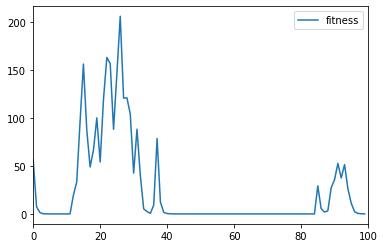

In [8]:
opt.run(total_generations)

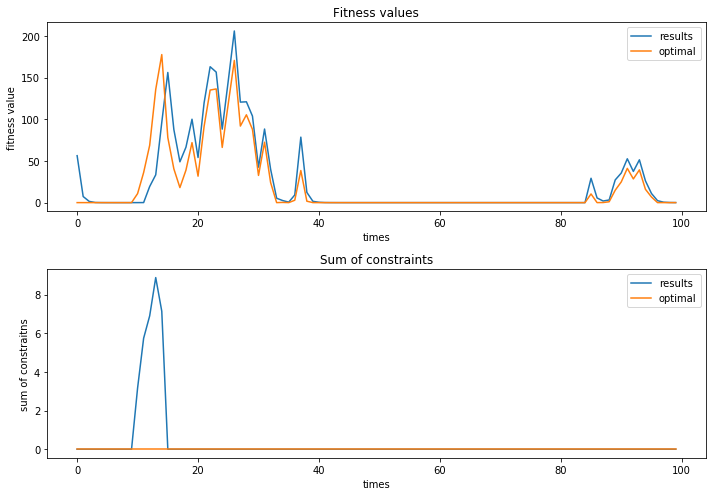

In [9]:
opt.recorder.plot();

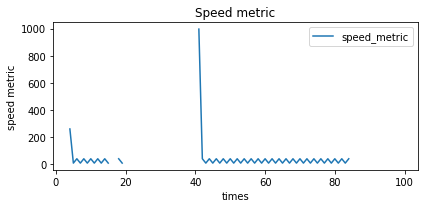

In [10]:
opt.recorder.plot_metrics();

In [13]:
pred = opt.nn_trainer.get_next_best()
pred

tensor([ 0.3929, -0.3024,  0.1503,  0.6499, -0.0371,  0.4643, -0.2699,  0.9282,
        -0.2405,  0.2618,  0.1573,  0.1650,  0.1537,  0.4565,  0.0582,  0.0551,
         0.0694, -0.3494, -0.0885,  0.2253,  0.5171,  0.7423, -0.1768,  0.0620,
         0.3507,  0.1978,  0.6112,  0.0115,  0.0780,  0.0155])

In [14]:
fitness_func(opt.best, 0, 0), fitness_func(pred, 0, 0)

(0.059616797, tensor(3.8399))

In [15]:
constraint_func(opt.best, ab, opt.time-1), constraint_func(pred, ab, opt.time-1)

(-5.534947117184242, tensor(-4.5979))

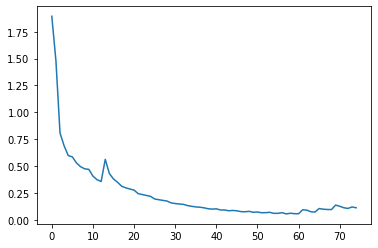

In [17]:
plt.plot(opt.nn_trainer.train_losses)